In [2]:
import pickle
import keras
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
from skimage.transform import resize
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, Concatenate,BatchNormalization,Conv2DTranspose, MaxPooling2D, Dropout,UpSampling2D, Flatten, Reshape
from keras.regularizers import l2,l1
from keras.models import load_model
from keras.utils import plot_model
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score

from keras.preprocessing.image import ImageDataGenerator

random.seed(42)


import time
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

class LossLog(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_begin(self,epoch,logs={}):
        self.losses_epoch = []

    def on_epoch_end(self,epoch,logs={}):
        self.losses.append(self.losses_epoch)

    def on_batch_end(self, batch, logs={}):
        self.losses_epoch.append(logs.get('loss'))

    def on_train_end(self,logs={}):
        layers=len(self.model.layers)
        timestr = time.strftime("%Y%m%d-%H%M%S")
        save_loss_to_csv(self.losses,layers,timestr)

def save_pickle(path, obj):
    print('Saving object in: ' + path)
    with open(path, 'wb+') as f:
        pickle.dump(obj, f)

def load_pickle(path):
    print('Loading object from: ' + path)
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

def save_model(model,filename):
    model.save("/content/"+filename+".h5")    

def display_images(original,reconstructed):
    res=np.concatenate((original,reconstructed),axis=1)
    plt.imshow(res)
    plt.show()

def save_loss_to_csv(losses,layers,timestr):
    filepath="/content/"+timestr+"_layers-"+str(layers)+".csv"

    with open(filepath, 'w+') as csvFile:
        writer = csv.writer(csvFile)
        for epoch in losses:
            writer.writerow(epoch)

    csvFile.close()
    
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

  
def dice_coef_loss(y_true, y_pred):
  return -dice_coef(y_true, y_pred)    

Using TensorFlow backend.


     |████████████████████████████████| 993kB 3.4MB/s 


# **Data visualization**

In [0]:
def callback_wrapper(model_name):
  callbacks = [EarlyStopping(patience=15, verbose=1),  ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),ModelCheckpoint(model_name, verbose=1, save_best_only=True, save_weights_only=False)]
  return callbacks
    


def visualize_model(results):
  plt.figure(figsize=(8, 8))
  plt.title("Learning curve")
  plt.plot(results.history["loss"], label="loss")
  plt.plot(results.history["val_loss"], label="val_loss")
  plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
  plt.xlabel("Epochs")
  plt.ylabel("log_loss")
  plt.legend();
  
def visualize_model_acc(results):
  plt.figure(figsize=(8, 8))
  plt.title("Learning curve")
  plt.plot(results.history["acc"], label="loss")
  plt.plot(results.history["val_acc"], label="val_acc")
  plt.plot( np.argmax(results.history["val_acc"]), np.max(results.history["val_acc"]), marker="x", color="r", label="best model")
  plt.xlabel("Epochs")
  plt.ylabel("Acuracy")
  plt.legend();



# *Load data*

In [5]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
# https://drive.google.com/open?id=
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
train_file_id = '1R3OyTT5AdXBtzmy4_ZMszfdAdXe44UpH'
val_file_id = '13kFL2tLb_C1ucde4pPNF1k9VPxBg5FyF'
test_file_id = '1ax-6bJ8EeWZDHJ6kDwzNdJ8VaNkVQXjm'

y_train_file_id = '1bGpHoADopA93KeCZtIrRoXRo4rfZH2Fs'
y_val_file_id = '13stfhHi_TsSEmws3t__lJZ55eg-uOwYi'
y_test_file_id = '16mNHBA-3EBLQ_nX6eAu-FRDUgWiFmFV_'


x_train_file = drive.CreateFile({'id': train_file_id})
x_val_file = drive.CreateFile({'id': val_file_id})
x_test_file = drive.CreateFile({'id': test_file_id})

y_train_file = drive.CreateFile({'id': y_train_file_id})
y_val_file = drive.CreateFile({'id': y_val_file_id})
y_test_file = drive.CreateFile({'id': y_test_file_id})


x_train_file.GetContentFile('x_train')
x_val_file.GetContentFile('x_val')
x_test_file.GetContentFile('x_test')

y_train_file.GetContentFile('y_train')
y_val_file.GetContentFile('y_val')
y_test_file.GetContentFile('y_test')


x_train=load_pickle('x_train')
y_train=load_pickle("y_train")

x_val=load_pickle('x_val')
y_val=load_pickle("y_val")

x_test=load_pickle("x_test")
y_test=load_pickle("y_test")


x_train_file=0
x_val_file=0
x_test_file=0

y_train_file=0
y_val_file=0
y_test_file=0

Loading object from: x_train
Loading object from: y_train
Loading object from: x_val
Loading object from: y_val
Loading object from: x_test
Loading object from: y_test


In [0]:
y_train_ind1=np.array(np.where(y_train[:,0]==1)[0])
y_train_ind1=np.append(y_train_ind1,np.random.choice(np.where(y_train[:,0]==0)[0],400,replace=False))
          
y_train_ind2=np.array(np.where(y_train[:,1]==1)[0])
y_train_ind2=np.append(y_train_ind2,np.random.choice(np.where(y_train[:,1]==0)[0],600,replace=False))
          
y_train_ind3=np.array(np.where(y_train[:,2]==1)[0])
y_train_ind3=np.append(y_train_ind3,np.random.choice(np.where(y_train[:,2]==0)[0],600,replace=False))
          
y_train_ind4=np.array(np.where(y_train[:,3]==1)[0])
y_train_ind4=np.append(y_train_ind4,np.random.choice(np.where(y_train[:,3]==0)[0],600,replace=False))
          


x_train1=x_train[y_train_ind1]
x_train2=x_train[y_train_ind2]
x_train3=x_train[y_train_ind3]
x_train4=x_train[y_train_ind4]


y_train1=y_train[y_train_ind1][:,0]
y_train2=y_train[y_train_ind2][:,1]
y_train3=y_train[y_train_ind3][:,2]
y_train4=y_train[y_train_ind4][:,3]

y_val1=y_val[:,0]
y_val2=y_val[:,1]
y_val3=y_val[:,2]
y_val4=y_val[:,3]


# *Data augmentation*

In [0]:
image_size=128
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True)

datagen.fit(x_train)


# *Build model*

## **Autoencoder**

In [8]:


# Encoder architecture for feature extraction
input_im = Input(shape=(image_size, image_size, 3))  

encoder=Conv2D(64, (2,2), activation='relu', padding='same')(input_im) # 16 kernels of size 3x3 - The output is of size 16*size_image*size_image.
encoder=MaxPooling2D((2, 2), padding='same')(encoder) 
# encoder=BatchNormalization()(encoder)
encoder=Conv2D(256, (2,2),activation='relu', padding='same')(encoder)
encoder=MaxPooling2D((2, 2), padding='same')(encoder)
# encoder=BatchNormalization()(encoder)
encoder=Conv2D(16, (2, 2),activation='relu', padding='same')(encoder)
encoder=MaxPooling2D((2, 2), padding='same')(encoder)

# Flatten the output of the encoder for to feed the dense layers
output_encoder=Flatten()(encoder)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
decoder=Conv2DTranspose(64,(2,2),strides=(2,2), activation='relu', padding='same')(encoder)
decoder=Conv2DTranspose(256,(2,2),strides=(2,2), activation='relu', padding='same')(decoder)
decoder=Conv2DTranspose(16,(2,2),strides=(2,2), activation='relu', padding='same')(decoder)
decoder=Conv2DTranspose(3,(2,2), activation='relu', padding='same')(decoder)


In [0]:
autoencoder=Model(inputs=input_im,outputs=decoder)
autoencoder.compile(loss='mean_squared_error', optimizer='adam')



In [11]:
result_autoencoder=autoencoder.fit(x_train, x_train, batch_size=32, epochs=50,validation_data=(x_val, x_val),callbacks=callback_wrapper('autoencoder.h5'),shuffle=True)


Instructions for updating:
Use tf.cast instead.
Train on 1832 samples, validate on 229 samples
Epoch 1/50
1832/1832 [==============================] - 11s 6ms/step - loss: 0.0433 - val_loss: 0.0174

Epoch 00001: val_loss improved from inf to 0.01744, saving model to autoencoder.h5
Epoch 2/50
1832/1832 [==============================] - 4s 2ms/step - loss: 0.0165 - val_loss: 0.0150

Epoch 00002: val_loss improved from 0.01744 to 0.01502, saving model to autoencoder.h5
Epoch 3/50
1832/1832 [==============================] - 4s 2ms/step - loss: 0.0145 - val_loss: 0.0130

Epoch 00003: val_loss improved from 0.01502 to 0.01296, saving model to autoencoder.h5
Epoch 4/50
1832/1832 [==============================] - 4s 2ms/step - loss: 0.0128 - val_loss: 0.0109

Epoch 00004: val_loss improved from 0.01296 to 0.01088, saving model to autoencoder.h5
Epoch 5/50
1832/1832 [==============================] - 4s 2ms/step - loss: 0.0101 - val_loss: 0.0084

Epoch 00005: val_loss improved from 0.01088 t

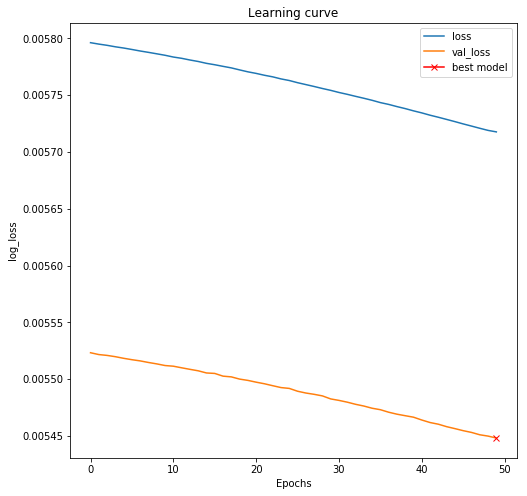

In [98]:
visualize_model(result_autoencoder)

In [22]:
print(y_val[4])

[0 1 0 0]


Text(0.5, 1.0, 'Reconstruction')

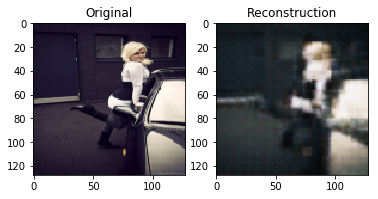

In [12]:

original=x_val[4:]
f = plt.figure()    
reconstruction=autoencoder.predict(original)
f.add_subplot(1,2, 1)
plt.imshow(original[0])
plt.title("Original")
f.add_subplot(1,2, 2)
plt.imshow(reconstruction[0])
plt.title("Reconstruction")


In [0]:
plot_model(autoencoder, to_file='autoencoder.jpg', show_shapes=True, show_layer_names=False)


In [0]:
autoencoder=load_model('autoencoder.h5')

In [0]:
autoencoder_trainable= keras.models.clone_model(autoencoder)


In [0]:
for layer in autoencoder.layers:
  layer.trainable=False

In [0]:
# encoder_train=Flatten()(autoencoder_trainable.layers[6].output)
# single_classifier=Dropout(0.2)(encoder_train)


single_classifier=Dropout(0.2)(output_encoder)
single_classifier=Dense(512,activation='relu')(single_classifier)
single_classifier=BatchNormalization()(single_classifier)
single_classifier=Dropout(0.4)(single_classifier)
single_classifier=Dense(512,activation='relu')(single_classifier)
single_classifier=BatchNormalization()(single_classifier)
single_classifier=Dropout(0.2)(single_classifier)
single_classifier=Dense(4,activation='softmax')(single_classifier)

In [0]:

# Classification layers
classifier1=Dropout(0.2)(output_encoder)
classifier1=Dense(512,activation='relu')(classifier1)
classifier1=BatchNormalization()(classifier1)
classifier1=Dropout(0.2)(classifier1)
classifier1=Dense(1,activation='sigmoid')(classifier1)





In [0]:
# classifier4=Dropout(0.2)(output_encoder)
# classifier4=Dense(256,activation='relu',kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01))(classifier4)
# classifier4=BatchNormalization()(classifier4)
# classifier4=Dropout(0.6)(classifier4)
# classifier4=Dense(1,activation='softmax')(classifier4)

In [0]:
# classifier2=Dropout(0.2)(output_encoder)
# classifier2=Dense(256,activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(classifier2)
# classifier2=BatchNormalization()(classifier2)
# classifier2=Dropout(0.6)(classifier2)
# classifier2=Dense(1,activation='softmax')(classifier2)

In [0]:
# classifier3=Dropout(0.2)(output_encoder)
# classifier3=Dense(100,activation='relu',kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1))(classifier3)
# classifier3=BatchNormalization()(classifier3)
# classifier3=Dropout(0.6)(classifier3)
# classifier3=Dense(1,activation='softmax')(classifier3)

# *Model training*

In [0]:
class1=Model(inputs=input_im,outputs=classifier1)
class2=keras.models.clone_model(class1)
class3=keras.models.clone_model(class1)
class4=keras.models.clone_model(class1)

models=[class1,class2,class3,class4]

model_aux=[]

for i,model in enumerate(models):
  model.layers[1].name = model.layers[1].name + str(i)
  x=model.layers[1](input_im)
  for layer in model.layers[2:]:
    layer.name = layer.name + str(i)
    x=layer(x)
  model_aux.append(x)
  
  
merge = keras.layers.concatenate([model for model in model_aux])


global_output=Dense(1024,activation='relu')(merge)
global_output=Dropout(0.6)(global_output)
global_output=Dense(4,activation='softmax')(global_output)



classifier=Model(inputs=input_im,outputs=global_output)
single_classifier_model=Model(inputs=input_im,outputs=single_classifier)
# single_classifier_model=Model(inputs=input_im.input,outputs=single_classifier)

In [37]:
plot_model(classifier, to_file='classifier.jpg', show_shapes=True, show_layer_names=True)
single_classifier_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 128, 128, 64)      832       
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_200 (Conv2D)          (None, 64, 64, 256)       65792     
_________________________________________________________________
max_pooling2d_200 (MaxPoolin (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_300 (Conv2D)          (None, 32, 32, 16)        16400     
_________________________________________________________________
max_pooling2d_300 (MaxPoolin (None, 16, 16, 16)        0         
__________

In [0]:

single_classifier_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
result_single_classifier=single_classifier_model.fit_generator(datagen.flow(x_train, y_train, batch_size=64), callbacks=callback_wrapper('single_fixed.h5'),shuffle=True,steps_per_epoch=len(x_train) / 64,epochs=100, validation_data=(x_val, y_val))


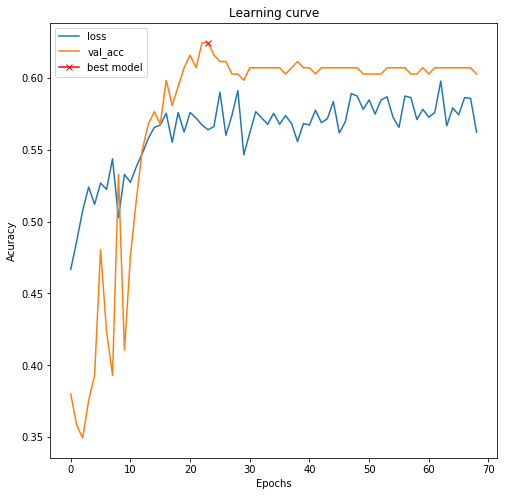

In [114]:
visualize_model_acc(result_single_classifier)

In [77]:
print(single_classifier_model.evaluate(x_test,y_test)[1])

230/230 [==============================] - 0s 766us/step
0.5347826086956522


In [0]:
for layer in autoencoder.layers:
  layer.trainable=True

In [59]:
single_classifier_random=keras.models.clone_model(single_classifier_model)
single_classifier_random.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
result_single_classifier_random=single_classifier_random.fit_generator(datagen.flow(x_train, y_train, batch_size=64), callbacks=callback_wrapper('single_random'),shuffle=True,steps_per_epoch=len(x_train) / 64,epochs=100, validation_data=(x_val, y_val))


Epoch 1/100
29/28 [==============================] - 8s 273ms/step - loss: 1.9332 - acc: 0.3355 - val_loss: 2.5202 - val_acc: 0.2838

Epoch 00001: val_loss improved from inf to 2.52015, saving model to single_random
Epoch 2/100
29/28 [==============================] - 4s 146ms/step - loss: 1.5533 - acc: 0.4209 - val_loss: 1.5527 - val_acc: 0.3581

Epoch 00002: val_loss improved from 2.52015 to 1.55267, saving model to single_random
Epoch 3/100
29/28 [==============================] - 6s 204ms/step - loss: 1.3566 - acc: 0.4819 - val_loss: 1.9653 - val_acc: 0.4148

Epoch 00003: val_loss did not improve from 1.55267
Epoch 4/100
29/28 [==============================] - 6s 204ms/step - loss: 1.3035 - acc: 0.5135 - val_loss: 2.4028 - val_acc: 0.2838

Epoch 00004: val_loss did not improve from 1.55267
Epoch 5/100
29/28 [==============================] - 6s 209ms/step - loss: 1.2198 - acc: 0.5234 - val_loss: 1.5314 - val_acc: 0.4760

Epoch 00005: val_loss improved from 1.55267 to 1.53138, savi

In [115]:
print(single_classifier_random.evaluate(x_test,y_test)[1])

230/230 [==============================] - 0s 752us/step
0.6130434785200202


In [48]:
single_classifier_random.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_100000 (Conv2D)       (None, 128, 128, 64)      832       
_________________________________________________________________
max_pooling2d_100000 (MaxPoo (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_200000 (Conv2D)       (None, 64, 64, 256)       65792     
_________________________________________________________________
max_pooling2d_200000 (MaxPoo (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_300000 (Conv2D)       (None, 32, 32, 16)        16400     
_________________________________________________________________
max_pooling2d_300000 (MaxPoo (None, 16, 16, 16)        0         
__________

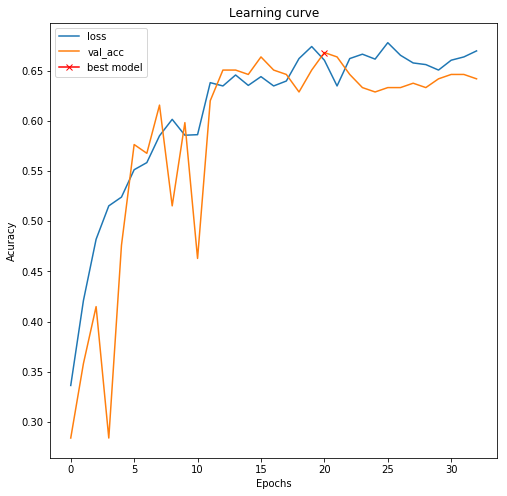

In [60]:
visualize_model_acc(result_single_classifier_random)

In [106]:
class1.compile(loss = 'binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
result_class1=class1.fit_generator(datagen.flow(x_train1, y_train1, batch_size=64), shuffle=True,steps_per_epoch=len(x_train) / 64,epochs=50, callbacks=callback_wrapper('class1.h5'),validation_data=(x_val, y_val1))


Epoch 1/50
29/28 [==============================] - 9s 296ms/step - loss: 0.5167 - acc: 0.7815 - val_loss: 1.1657 - val_acc: 0.2314

Epoch 00001: val_loss improved from inf to 1.16570, saving model to class1.h5
Epoch 2/50
29/28 [==============================] - 4s 133ms/step - loss: 0.4618 - acc: 0.7910 - val_loss: 0.7038 - val_acc: 0.5415

Epoch 00002: val_loss improved from 1.16570 to 0.70375, saving model to class1.h5
Epoch 3/50
29/28 [==============================] - 6s 191ms/step - loss: 0.4641 - acc: 0.7979 - val_loss: 0.6135 - val_acc: 0.6638

Epoch 00003: val_loss improved from 0.70375 to 0.61352, saving model to class1.h5
Epoch 4/50
29/28 [==============================] - 6s 190ms/step - loss: 0.4541 - acc: 0.8032 - val_loss: 0.7156 - val_acc: 0.5197

Epoch 00004: val_loss did not improve from 0.61352
Epoch 5/50
29/28 [==============================] - 5s 188ms/step - loss: 0.4385 - acc: 0.8087 - val_loss: 0.5705 - val_acc: 0.7205

Epoch 00005: val_loss improved from 0.6135

KeyboardInterrupt: ignored

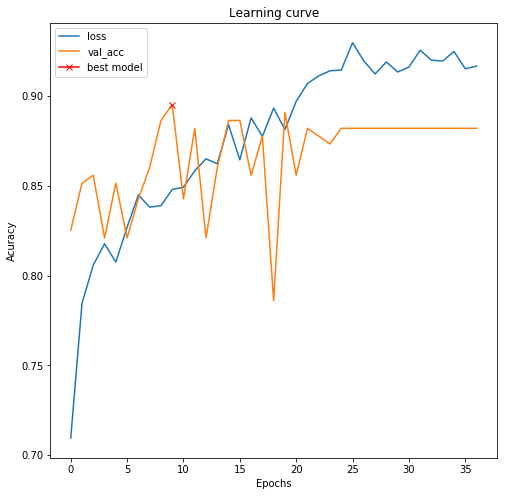

In [105]:
visualize_model_acc(result_class1)

In [107]:
class2=keras.models.clone_model(class1)

class2.compile(loss = 'binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])

class2.summary()
result_class2=class2.fit_generator(datagen.flow(x_train2, y_train2, batch_size=64), shuffle=True,steps_per_epoch=len(x_train) / 64,epochs=50, callbacks=callback_wrapper('class2.h5'),validation_data=(x_val, y_val2))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 128, 128, 64)      832       
_________________________________________________________________
max_pooling2d_160 (MaxPoolin (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_170 (Conv2D)          (None, 64, 64, 256)       65792     
_________________________________________________________________
max_pooling2d_170 (MaxPoolin (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_180 (Conv2D)          (None, 32, 32, 16)        16400     
_________________________________________________________________
max_pooling2d_180 (MaxPoolin (None, 16, 16, 16)        0         
__________

KeyboardInterrupt: ignored

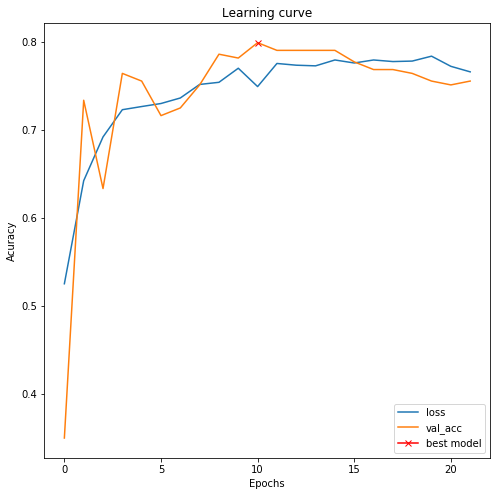

In [0]:
visualize_model_acc(result_class2)

In [108]:
class3.compile(loss = 'binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
result_class3=class3.fit_generator(datagen.flow(x_train3, y_train3, batch_size=64), shuffle=True,steps_per_epoch=len(x_train) / 64,epochs=50, callbacks=callback_wrapper('class3.h5'),validation_data=(x_val, y_val3))


Epoch 1/50
29/28 [==============================] - 9s 295ms/step - loss: 0.6946 - acc: 0.6603 - val_loss: 0.6707 - val_acc: 0.5764

Epoch 00001: val_loss improved from inf to 0.67065, saving model to class3.h5
Epoch 2/50
29/28 [==============================] - 4s 128ms/step - loss: 0.5746 - acc: 0.7053 - val_loss: 0.6826 - val_acc: 0.5459

Epoch 00002: val_loss did not improve from 0.67065
Epoch 3/50
29/28 [==============================] - 5s 187ms/step - loss: 0.5516 - acc: 0.7214 - val_loss: 0.6058 - val_acc: 0.7293

Epoch 00003: val_loss improved from 0.67065 to 0.60581, saving model to class3.h5
Epoch 4/50
29/28 [==============================] - 5s 186ms/step - loss: 0.5573 - acc: 0.7060 - val_loss: 0.6527 - val_acc: 0.6114

Epoch 00004: val_loss did not improve from 0.60581
Epoch 5/50
29/28 [==============================] - 5s 188ms/step - loss: 0.5345 - acc: 0.7224 - val_loss: 0.6133 - val_acc: 0.6987

Epoch 00005: val_loss did not improve from 0.60581
Epoch 6/50
29/28 [====

KeyboardInterrupt: ignored

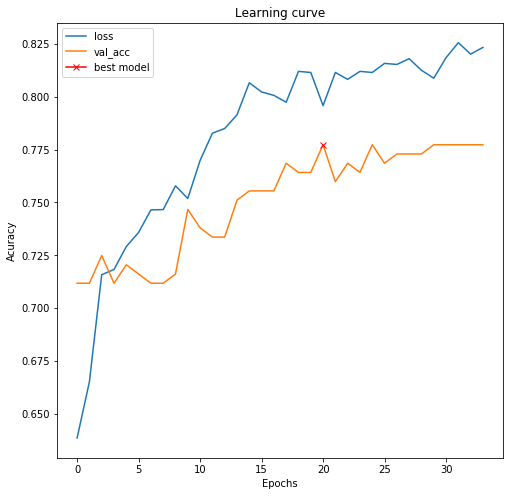

In [0]:
visualize_model_acc(result_class3)

In [109]:
class4.compile(loss = 'binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
result_class4=class4.fit_generator(datagen.flow(x_train4, y_train4, batch_size=64), shuffle=True,steps_per_epoch=len(x_train) / 64,epochs=50, callbacks=callback_wrapper('class4.h5'),validation_data=(x_val, y_val4))


Epoch 1/50
29/28 [==============================] - 8s 284ms/step - loss: 0.7824 - acc: 0.6081 - val_loss: 0.5287 - val_acc: 0.7948

Epoch 00001: val_loss improved from inf to 0.52872, saving model to class3.h5
Epoch 2/50
29/28 [==============================] - 4s 127ms/step - loss: 0.6113 - acc: 0.6765 - val_loss: 0.5816 - val_acc: 0.8035

Epoch 00002: val_loss did not improve from 0.52872
Epoch 3/50
29/28 [==============================] - 6s 190ms/step - loss: 0.6087 - acc: 0.6582 - val_loss: 0.5101 - val_acc: 0.7948

Epoch 00003: val_loss improved from 0.52872 to 0.51009, saving model to class3.h5
Epoch 4/50
 8/28 [=======>......................] - ETA: 3s - loss: 0.5965 - acc: 0.6953

KeyboardInterrupt: ignored

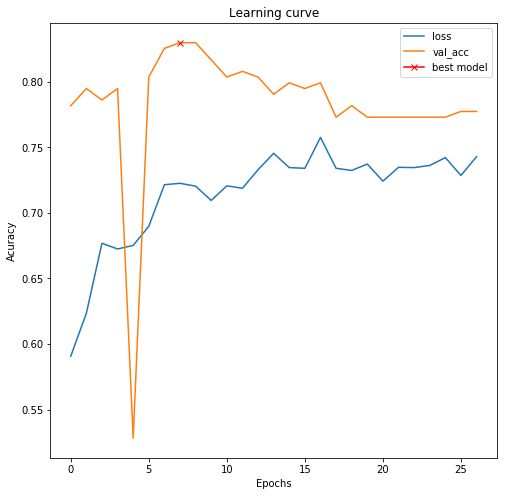

In [0]:
visualize_model_acc(result_class4)

In [0]:
for layer in class1.layers:
  layer.trainable=False
  
for layer in class2.layers[1:]:
  layer.trainable=False
#   layer

for layer in class3.layers:
  layer.trainable=False
  
for layer in class4.layers:
  layer.trainable=False
  
  

In [111]:
classifier=Model(inputs=input_im,outputs=global_output)
classifier.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
classifier.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_160 (Conv2D)             (None, 128, 128, 64) 832         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_161 (Conv2D)             (None, 128, 128, 64) 832         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_162 (Conv2D)             (None, 128, 128, 64) 832         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_163

In [112]:
result_global=classifier.fit_generator(datagen.flow(x_train, y_train, batch_size=64), callbacks=callback_wrapper('global_fixed.h5'),shuffle=True,steps_per_epoch=len(x_train) / 64,epochs=100, validation_data=(x_val, y_val))


Epoch 1/100
29/28 [==============================] - 9s 325ms/step - loss: 1.2687 - acc: 0.4232 - val_loss: 1.3395 - val_acc: 0.3188

Epoch 00001: val_loss improved from inf to 1.33947, saving model to global_fixed.h5
Epoch 2/100
29/28 [==============================] - 5s 161ms/step - loss: 1.1689 - acc: 0.5089 - val_loss: 1.2291 - val_acc: 0.4847

Epoch 00002: val_loss improved from 1.33947 to 1.22906, saving model to global_fixed.h5
Epoch 3/100
29/28 [==============================] - 6s 214ms/step - loss: 1.1309 - acc: 0.5258 - val_loss: 1.2416 - val_acc: 0.4934

Epoch 00003: val_loss did not improve from 1.22906
Epoch 4/100
29/28 [==============================] - 6s 215ms/step - loss: 1.1195 - acc: 0.5447 - val_loss: 1.1866 - val_acc: 0.5197

Epoch 00004: val_loss improved from 1.22906 to 1.18657, saving model to global_fixed.h5
Epoch 5/100
29/28 [==============================] - 6s 213ms/step - loss: 1.1097 - acc: 0.5509 - val_loss: 1.1721 - val_acc: 0.5328

Epoch 00005: val_lo

KeyboardInterrupt: ignored

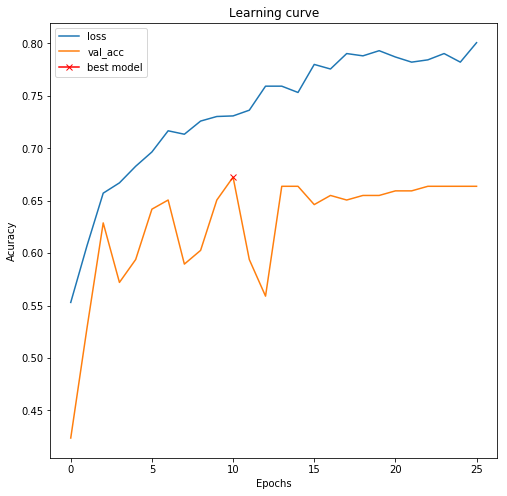

In [0]:
visualize_model_acc(result_global)

In [113]:
print(classifier.evaluate(x_test,y_test)[1])

230/230 [==============================] - 0s 2ms/step
0.521739130564358


In [141]:
from keras.applications.vgg16 import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

vgg = Model(inputs=base_model.input, outputs=predictions)


for layer in base_model.layers:
    layer.trainable = False
    
vgg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
vgg_res=vgg.fit_generator(datagen.flow(x_train, y_train, batch_size=64), callbacks=callback_wrapper('vgg.h5'),shuffle=True,steps_per_epoch=len(x_train) / 64,epochs=100, validation_data=(x_val, y_val))
    


Epoch 1/100
29/28 [==============================] - 12s 414ms/step - loss: 8.5103 - acc: 0.4248 - val_loss: 7.6102 - val_acc: 0.4978

Epoch 00001: val_loss improved from inf to 7.61023, saving model to vgg.h5
Epoch 2/100
29/28 [==============================] - 5s 189ms/step - loss: 7.8544 - acc: 0.4901 - val_loss: 7.9340 - val_acc: 0.4629

Epoch 00002: val_loss did not improve from 7.61023
Epoch 3/100
29/28 [==============================] - 7s 224ms/step - loss: 7.6248 - acc: 0.5137 - val_loss: 7.0117 - val_acc: 0.5109

Epoch 00003: val_loss improved from 7.61023 to 7.01167, saving model to vgg.h5
Epoch 4/100
29/28 [==============================] - 7s 227ms/step - loss: 7.4941 - acc: 0.5025 - val_loss: 6.9071 - val_acc: 0.5066

Epoch 00004: val_loss improved from 7.01167 to 6.90709, saving model to vgg.h5
Epoch 5/100
29/28 [==============================] - 6s 222ms/step - loss: 7.2205 - acc: 0.5150 - val_loss: 7.0633 - val_acc: 0.4847

Epoch 00005: val_loss did not improve from 6.

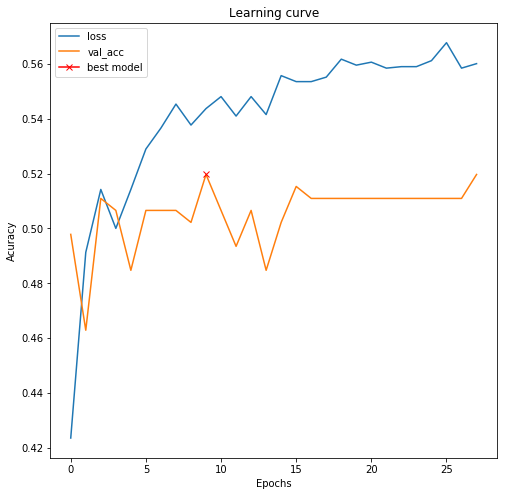

In [142]:
visualize_model_acc(vgg_res)

In [1]:

for layer in base_model.layers:
    layer.trainable = True
    
vgg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
vgg_result=vgg.fit_generator(datagen.flow(x_train, y_train, batch_size=64), callbacks=callback_wrapper('vgg2.h5'),shuffle=True,steps_per_epoch=len(x_train) / 64,epochs=100, validation_data=(x_val, y_val))

    

NameError: ignored